In [1]:
import pandas as pd
from sklearn import model_selection
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv('train.csv')
y = train.Transported
test = pd.read_csv('test.csv')
train.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
8057,8615_01,Earth,False,E/565/S,55 Cancri e,50.0,False,0.0,0.0,117.0,712.0,0.0,Kris Buckentry,True
3639,3913_01,Earth,False,F/738/S,NaN,23.0,False,0.0,93.0,1.0,0.0,542.0,Catha Waterson,False
4903,5225_01,Mars,True,E/334/S,TRAPPIST-1e,30.0,False,0.0,0.0,0.0,0.0,0.0,Chrets Sincy,True
3430,3699_04,Europa,False,C/123/P,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive,False
8337,8903_01,Earth,False,G/1437/S,TRAPPIST-1e,18.0,False,0.0,0.0,0.0,0.0,810.0,Darrie Herreras,False


In [3]:
# # create some folds for cross validation
# # create kfold column filled with -1
# train['kfold'] = -1

# # next we have to randomize the rows of data
# train = train.sample(frac=1).reset_index(drop = True)

# # specify target variable
# y = train.Transported.values

# # initiate the kfold class from model_selection module
# kf = model_selection.KFold(n_splits=5)

# # fill the new kfold columnm
# for f, (t_,v_) in enumerate(kf.split(X=train,y=y)):
#     train.loc[v_,'kfold'] = f

# # save the new csv with kfold column
# train.to_csv('train_folds.csv',
#             index = False)

In [4]:
# # target variable is transported
# # df = pd.read_csv('train_folds.csv')
# y = df.Transported
# df.sample(5)

In [5]:
# we observe that cabin can be disaggregated
# perhaps we can create a feature that includes total spend (room service, food court, mall, spa, VRdeck)
# additionally passenger name is composed of a first and last name that can be separated
train[['first_name','last_name']] = train.Name.str.split(' ', expand = True).iloc[:,0:2]
train[['deck', 'num', 'side']] = train['Cabin'].str.split('/', expand=True)
train['Total_spend'] = train.RoomService + train.FoodCourt + train.ShoppingMall + train.Spa + train.VRDeck    

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  first_name    8493 non-null   object 
 15  last_name     8493 non-null   object 
 16  deck          8494 non-null   object 
 17  num           8494 non-null   object 
 18  side          8494 non-null 

### Remarks:
- only variables without missing values are PassengerID and Transported (target variable)

/Users/lucasshwed/miniconda3/envs/data_science/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lucasshwed/miniconda3/envs/data_science/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lucasshwed/miniconda3/envs/data_science/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lucasshwed/miniconda3/envs/data_science/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lucasshwed/miniconda3/envs/data_science/lib/python3.9/site-packages/sklearn/model_selecti

<AxesSubplot:xlabel='x', ylabel='y'>

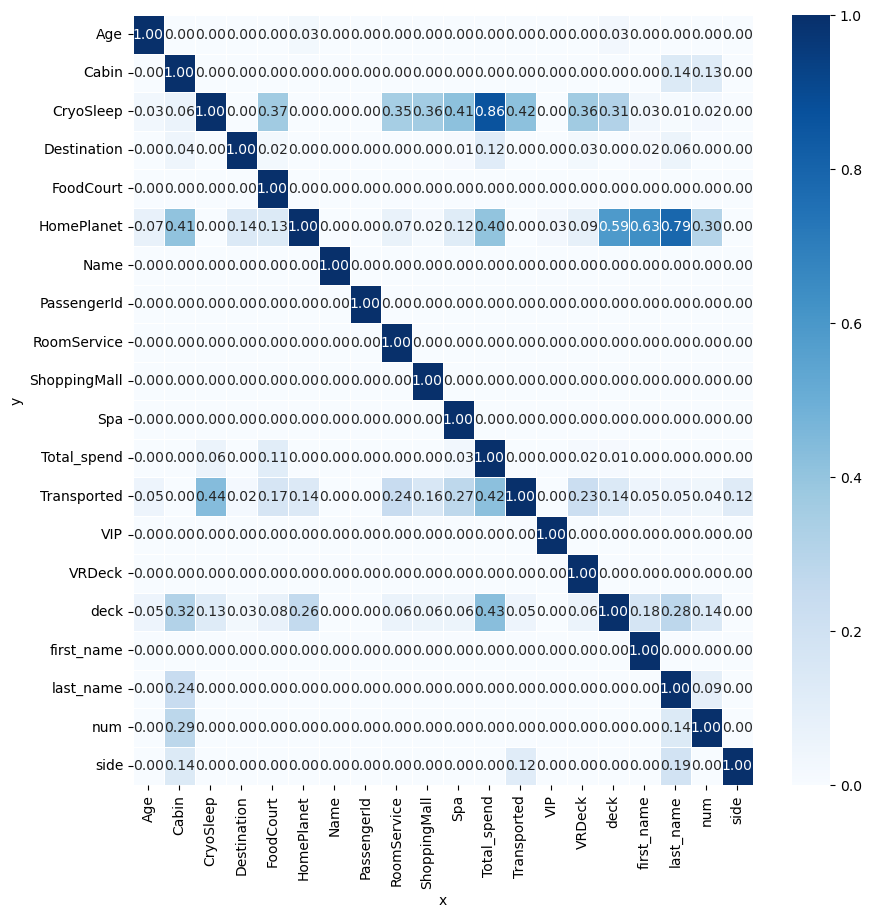

In [7]:
# let's examine some relationships that exist between factors
fig, ax = plt.subplots(figsize = (10,10))
ppscores = pps.matrix(train)
ppscores = ppscores[["x", "y", "ppscore"]].pivot(columns="x", index="y", values="ppscore")
sns.heatmap(
    ppscores, 
    vmin=0, 
    vmax=1, 
    cmap="Blues", 
    linewidths=0.7, 
    annot=True,
    fmt = '.2f'
)

#### Observations
- cyrosleep can be predicted by foodcourt, roomservice, shopping mall, SPA, VRdeck
- furthermore, total spend is a stronger predictor of cyrosleep
- last name has predictive power over home planet

In [8]:
# fill in missing homeplanet values based on lastname
home_planet_dict = train.groupby('last_name')['HomePlanet'].agg(pd.Series.mode).to_dict()
train.HomePlanet = train.HomePlanet.fillna(train.last_name.map(home_planet_dict))

CryoSleep
False    2304.194614
True        0.000000
Name: Total_spend, dtype: float64


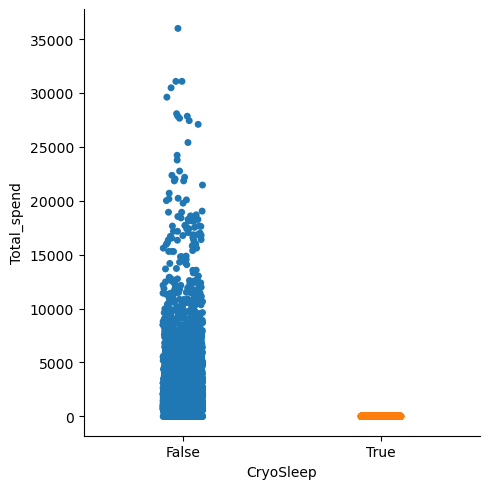

In [9]:
# fill in cyrosleep based on totalspend
sns.catplot(data = train,y = 'Total_spend',x = 'CryoSleep')
print(train.groupby('CryoSleep')['Total_spend'].mean())

In [10]:
# makes sense that if the passenger is in Cryosleep they cannot spend
train.loc[(train.CryoSleep.isna()) & (train.Total_spend == 0),'CryoSleep'] = True

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8686 non-null   object 
 2   CryoSleep     8563 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  first_name    8493 non-null   object 
 15  last_name     8493 non-null   object 
 16  deck          8494 non-null   object 
 17  num           8494 non-null   object 
 18  side          8494 non-null 

In [12]:
# need to fill homeplanet based on last_name
# total spend to predict cyrosleep

In [13]:
# only columns without missing values are passengerId and transported
# have some work to do in order to patch the dataset
num_cols = [
    'Age',
    'RoomService',
    'FoodCourt',
    'ShoppingMall',
    'Spa',
    'VRDeck',
    'Total_spend'
]
cat_cols = [
    'HomePlanet',
    'CryoSleep',
    # 'Cabin',
    'Destination',
    'VIP',
    'first_name',
    'last_name',
    'deck',
    'num',
    'side'
]

In [14]:
def feature_engineer(df):
    df[['first_name','last_name']] = df.Name.str.split(' ', expand = True).iloc[:,0:2]
    df[['deck', 'num', 'side']] = df['Cabin'].str.split('/', expand=True)
    df['Total_spend'] = df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck
    # fill in missing homeplanet values based on lastname
    home_planet_dict = df.groupby('last_name')['HomePlanet'].agg(pd.Series.mode).to_dict()
    df.HomePlanet = df.HomePlanet.fillna(df.last_name.map(home_planet_dict))
    # makes sense that if the passenger is in Cryosleep they cannot spend
    df.loc[(df.CryoSleep.isna()) & (df.Total_spend == 0),'CryoSleep'] = True
    # fill numerical values with median
    for i in num_cols:
        df[i] = df[i].fillna(df[i].median())
    # fill categorical variables with NONE
    for i in cat_cols:
        df[i] = df[i].fillna('NONE')
        df[i] = df[i].astype(str)
    return df

In [15]:
features = [
    f for f in train.columns if f not in (
        'kfold','PassengerId','Name','Transported','Cabin'
    )
]

In [16]:
train_df = feature_engineer(train)
test_df = feature_engineer(test)

# create full dataset with train and test to fit standardscaler and OHE
full_data = pd.concat(
        [train_df[features], test_df[features]],
        axis = 0
    )

array([[<AxesSubplot:xlabel='Age', ylabel='Age'>,
        <AxesSubplot:xlabel='RoomService', ylabel='Age'>,
        <AxesSubplot:xlabel='FoodCourt', ylabel='Age'>,
        <AxesSubplot:xlabel='ShoppingMall', ylabel='Age'>,
        <AxesSubplot:xlabel='Spa', ylabel='Age'>,
        <AxesSubplot:xlabel='VRDeck', ylabel='Age'>,
        <AxesSubplot:xlabel='Total_spend', ylabel='Age'>],
       [<AxesSubplot:xlabel='Age', ylabel='RoomService'>,
        <AxesSubplot:xlabel='RoomService', ylabel='RoomService'>,
        <AxesSubplot:xlabel='FoodCourt', ylabel='RoomService'>,
        <AxesSubplot:xlabel='ShoppingMall', ylabel='RoomService'>,
        <AxesSubplot:xlabel='Spa', ylabel='RoomService'>,
        <AxesSubplot:xlabel='VRDeck', ylabel='RoomService'>,
        <AxesSubplot:xlabel='Total_spend', ylabel='RoomService'>],
       [<AxesSubplot:xlabel='Age', ylabel='FoodCourt'>,
        <AxesSubplot:xlabel='RoomService', ylabel='FoodCourt'>,
        <AxesSubplot:xlabel='FoodCourt', ylabel='FoodC

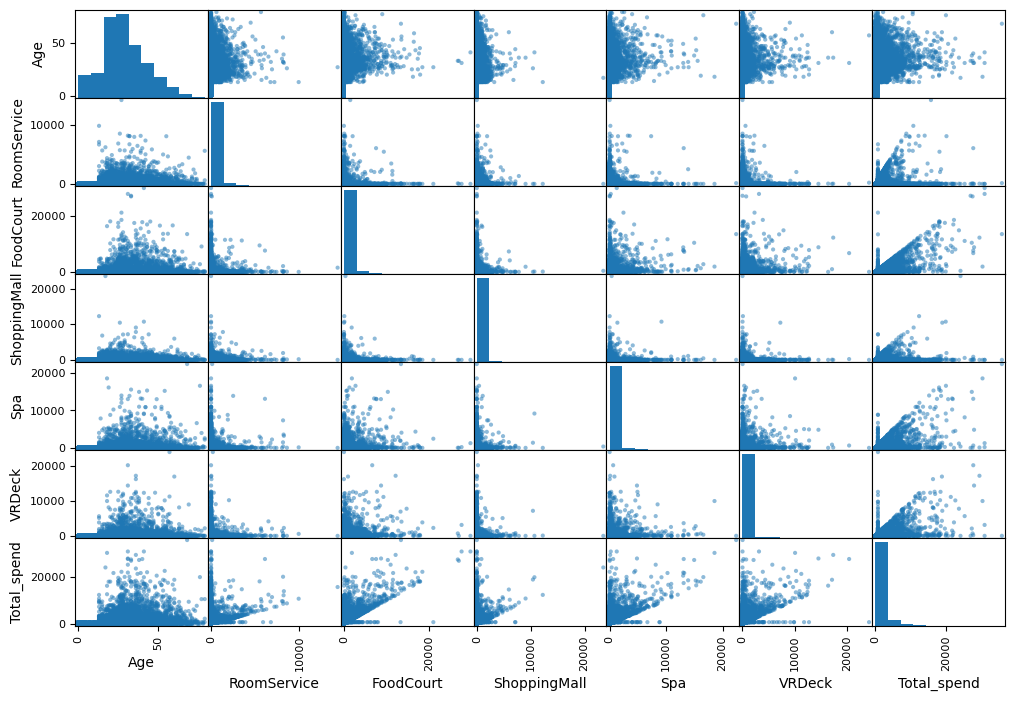

In [17]:
# another way to check correlations would be to use the scatter matrix attribute from pandas
# as correlation only checks for linear relationships we need to see if anyother patterns exist
from pandas.plotting import scatter_matrix

# attributes = ['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(train_df[num_cols], figsize = (12,8))

In [18]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,first_name,last_name,deck,num,side,Total_spend
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Maham,Ofracculy,B,0,P,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Juanna,Vines,F,0,S,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Altark,Susent,A,0,S,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Solam,Susent,A,0,S,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Willy,Santantines,F,1,S,1091.0


In [19]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12970 non-null  object 
 1   CryoSleep     12970 non-null  object 
 2   Destination   12970 non-null  object 
 3   Age           12970 non-null  float64
 4   VIP           12970 non-null  object 
 5   RoomService   12970 non-null  float64
 6   FoodCourt     12970 non-null  float64
 7   ShoppingMall  12970 non-null  float64
 8   Spa           12970 non-null  float64
 9   VRDeck        12970 non-null  float64
 10  first_name    12970 non-null  object 
 11  last_name     12970 non-null  object 
 12  deck          12970 non-null  object 
 13  num           12970 non-null  object 
 14  side          12970 non-null  object 
 15  Total_spend   12970 non-null  float64
dtypes: float64(7), object(9)
memory usage: 1.7+ MB


In [20]:
# pipeline to scale numerical values and one hot encode categorical values
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

full_pipeline  = ColumnTransformer([
    ('num',StandardScaler(),num_cols),
    ('cat',OneHotEncoder(),cat_cols),
])

full_pipeline.fit(full_data)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck',
                                  'Total_spend']),
                                ('cat', OneHotEncoder(),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP', 'first_name', 'last_name', 'deck',
                                  'num', 'side'])])

In [21]:
x_train = full_pipeline.transform(train_df[features])
x_test = full_pipeline.transform(test_df[features])

In [22]:
from sklearn import linear_model
lr_model = linear_model.LogisticRegression()
lr_model.fit(x_train, y)

/Users/lucasshwed/miniconda3/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [23]:
from sklearn import metrics
logres_preds = lr_model.predict(x_train)
print(f'AUC = {round(metrics.roc_auc_score(y,logres_preds),3)}')

AUC = 0.904


In [24]:
# create predictions on test set
test_preds = lr_model.predict(x_test)
sub_logres = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Transported':test_preds
})

In [25]:
sub_logres.to_csv('logres_submission.csv',
                  index = False)

In [26]:
from sklearn import ensemble

model = ensemble.RandomForestClassifier(n_jobs = -1,n_estimators = 2)
param_grid = {
    'n_estimators':list(range(10,101,10))
}
rf_grid = GridSearchCV(estimator = model, param_grid = param_grid)
rf_grid.fit(x_train,y)
rf_preds = rf_grid.predict(x_train)
print(f'AUC = {round(metrics.roc_auc_score(y,rf_preds),3)}')

AUC = 1.0


In [27]:
rf_test_preds = rf_grid.predict(x_test)
sub_rf = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Transported':rf_test_preds
})
sub_rf.to_csv('rf_submission.csv',
              index = False)

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors':list(range(1,50,1))
}
knn_grid = GridSearchCV(estimator = knn, param_grid = param_grid)
knn_grid.fit(x_train, y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]})

In [29]:
knn_preds = knn_grid.predict(x_train)
print(f'AUC = {round(metrics.roc_auc_score(y,knn_preds),3)}')

AUC = 0.809


In [30]:
knn_test_preds = knn_grid.predict(x_test)
sub_knn = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Transported':knn_test_preds
})
sub_knn.to_csv('knn_submission.csv',
              index = False)

In [32]:
from sklearn.svm import SVC

model = SVC()
param_grid = {
    "kernel": ["linear","rbf"],
    "C":[0.1,1,10]
}
svc_grid = GridSearchCV(estimator = model, param_grid = param_grid)
svc_grid.fit(x_train,y)
svm_preds = svc_grid.predict(x_train)
print(f'AUC = {round(metrics.roc_auc_score(y,svm_preds),3)}')


AUC = 0.855


In [34]:
svm_test_preds = svc_grid.predict(x_test)
sub_svm = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Transported':svm_test_preds
})
sub_svm.to_csv('svm_submission.csv',
              index = False)

In [35]:
import xgboost as xgb

model = xgb.XGBClassifier(
    n_jobs = -1
)
model.fit(x_train,y)
xgb_preds = model.predict(x_train)
print(f'AUC = {round(metrics.roc_auc_score(y,xgb_preds),3)}')

/Users/lucasshwed/miniconda3/envs/data_science/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/lucasshwed/miniconda3/envs/data_science/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:49:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC = 0.868


In [37]:
xgb_test_preds = model.predict(x_test)
sub_xgb = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Transported':xgb_test_preds
})
sub_xgb.to_csv('xgb_submission.csv',
              index = False)

In [ ]:
model = SVC(probability = True)
param_grid = {
    "kernel": ["linear","rbf"],
    "C":[0.1,1,10]
}
svc_grid = GridSearchCV(estimator = model, param_grid = param_grid)
from sklearn.ensemble import VotingClassifier 
est_Ensemble = VotingClassifier(estimators=[('lr', lr_model), 
                                            ('rf', rf_grid),
                                            ('knn', knn_grid),
                                            ('svc', svc_grid)],
                                voting='soft',
                                weights=[1,1,1,1])
est_Ensemble

In [ ]:
est_Ensemble.fit(x_train,y)
ens_pred = est_Ensemble.predict(x_train)
print(f'AUC = {round(metrics.roc_auc_score(y,ens_pred),3)}')

In [ ]:
ens_test_preds = est_Ensemble.predict(x_test)
sub_ens = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Transported':ens_test_preds
})
sub_ens.to_csv('ens_submission.csv',
              index = False)

In [40]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

# model = SVC()
# param_grid = {
#     "kernel": ["linear","rbf"],
#     "C":[0.1,1,10]
# }
# svc_grid = GridSearchCV(estimator = model, param_grid = param_grid)
clf.fit(x_train,y)
nn_preds = clf.predict(x_train)
print(f'AUC = {round(metrics.roc_auc_score(y,nn_preds),3)}')


AUC = 0.941


/Users/lucasshwed/miniconda3/envs/data_science/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [41]:
nn_test_preds = clf.predict(x_test)
sub_nn = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Transported':nn_test_preds
})
sub_nn.to_csv('nn_submission.csv',
              index = False)

In [43]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
param_grid = {
    'n_estimators':list(range(10,101,10))
}
ada_grid = GridSearchCV(estimator = ada, param_grid = param_grid)
ada_grid.fit(x_train,y)
ada_preds = ada_grid.predict(x_train)
print(f'AUC = {round(metrics.roc_auc_score(y,ada_preds),3)}')


AUC = 0.797


In [44]:
ada_grid.best_params_

{'n_estimators': 60}

In [46]:
ada_test_preds = ada_grid.predict(x_test)
sub_ada = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Transported':ada_test_preds
})
sub_ada.to_csv('ada_submission.csv',
              index = False)